In [1]:
dir_data = '../data'
fname = 'AverageEnsemble_Raw.csv'

outside_fname = '/home/eunwoo/experiment/PSSC/Oneformer(instance)/result/background7_abandon65/total_sum_bg.pickle'

In [2]:
import sys
sys.path.append('../')

import os

import cv2
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from segformers.utils import custom_cmap, rle_encode

/home/dongjin/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def rle2mask(mask_rle, label=1, shape=(540, 960)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = label
    return img.reshape(shape)

In [4]:
df = pd.read_csv(os.path.join(dir_data, 'test.csv'))

with open(outside_fname, 'rb') as f:
    outside2 = pickle.load(f)[0]
outside2 = cv2.resize(outside2, (960, 540), interpolation=cv2.INTER_NEAREST)


In [5]:
with open('/home/eunwoo/experiment/PSSC/Oneformer(instance)/result/cross_ensemble/result_4_new.pickle', 'rb') as f:
    result_4 = pickle.load(f)

# load
with open('/home/eunwoo/experiment/PSSC/Oneformer(instance)/result/cross_ensemble/result_5_new.pickle', 'rb') as f:
    result_5 = pickle.load(f)

# load
with open('/home/eunwoo/experiment/PSSC/Oneformer(instance)/result/cross_ensemble/result_9_new.pickle', 'rb') as f:
    result_9 = pickle.load(f)

In [6]:
df = pd.read_csv(fname)

row = 0
before = []
after = []
result = []
for i in tqdm(range(1898)):
    mask = np.zeros((540, 960)) + 12
    for c in range(12):
        if not df.loc[row, 'mask_rle'] == '-1':
            m = rle2mask(df.loc[row, 'mask_rle'], label=1)
            mask[np.where(m == 1)] = c
        row +=1
    before.append(mask)

    outside1 = mask == 12
    
    mask = mask.copy()
    
    new_mask_4 = result_4[i]
    new_mask_5 = result_5[i]
    new_mask_9 = result_9[i]

    mask[np.where(new_mask_4 == 1)] = 4
    mask[np.where(new_mask_5 == 1)] = 5
    mask[np.where(new_mask_9 == 1)] = 9
    
    mask = mask.astype(np.int32)
    
    # Remove noise
    bincount = np.bincount(mask.flatten())
    noise_classes = np.where((bincount > 0) & (bincount < 30))[0]
    if len(noise_classes) > 0:
        for c in noise_classes:
            if c != 5:
                mask[np.where(mask == c)] = 12
                
    mask[np.where(outside1 == 1)] = 12
    mask[np.where(outside2 == 1)] = 12

    after.append(mask)
    # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
    for class_id in range(12):
        class_mask = (mask == class_id).astype(np.int32)
        if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
            mask_rle = rle_encode(class_mask)
            result.append(mask_rle)
        else: # 마스크가 존재하지 않는 경우 -1
            result.append(-1)
    

100%|██████████| 1898/1898 [01:06<00:00, 28.75it/s]


In [7]:
submit = pd.read_csv('../data/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,212628 5 212636 5 213573 1 213585 1 213587 24 ...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,598 276 1558 276 2517 278 3476 279 4436 280 53...
3,TEST_0000_class_3,207757 2 208707 21 209656 53 210608 74 210696 ...
4,TEST_0000_class_4,-1
...,...,...
22771,TEST_1897_class_7,152250 8 153208 28 154166 35 155124 38 156083 ...
22772,TEST_1897_class_8,103 532 677 127 857 5 1062 533 1637 127 1817 5...
22773,TEST_1897_class_9,-1
22774,TEST_1897_class_10,-1


In [8]:
submit.to_csv('./AverageEnemble_Enhancement_30.csv', index=False)

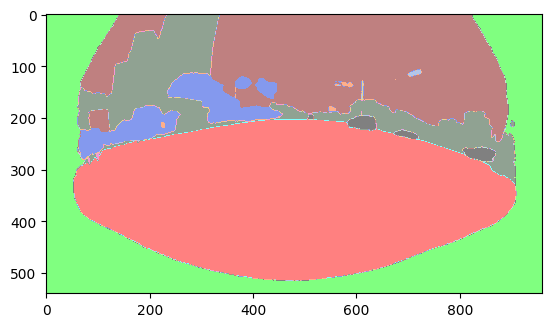

In [9]:
plt.imshow(before[785], cmap=custom_cmap, alpha=0.5)